# Plotting Tutorial
PyGSTi provides support for many different _plots_ you may want to make with your estimates.  In this tutorial, we give examples of how to generate the more commonly-used plots using the functions within `pygsti.report.plotting`.

In [1]:
from __future__ import print_function

In [2]:
import pygsti
import pygsti.report.plotting as pplt
import json
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Setup
Gather the data we need to create some example plots.

In [3]:
#Gate sets
gs_target = pygsti.io.load_gateset("tutorial_files/Example_Gateset.txt")
gs_mc2gst = pygsti.io.load_gateset("tutorial_files/Example_MC2GST_Gateset.txt")
gs_elgst = pygsti.io.load_gateset("tutorial_files/Example_eLGST_Gateset.txt")

#Data set
ds = pygsti.io.load_dataset("tutorial_files/Example_Dataset.txt", cache=False)

#Fiducials, germs, and maximum lengths (necessary to label the plots)
fiducialList = pygsti.io.load_gatestring_list("tutorial_files/Example_FiducialList.txt")
germList = pygsti.io.load_gatestring_list("tutorial_files/Example_GermsList.txt")
maxLengthList = json.load(open("tutorial_files/Example_maxLengths.json","r"))
specs = pygsti.construction.build_spam_specs(fiducialGateStrings=fiducialList)
strs = pygsti.construction.get_spam_strs(specs)

print("Gates     (%d): " % len(gs_target.gates), gs_target.gates.keys())
print("Fiducials (%d): " % len(fiducialList), map(str,fiducialList))
print("Germs     (%d): " % len(germList),map(str,germList))
print("Dataset has %d gate strings" % len(ds))

Loading tutorial_files/Example_Dataset.txt: 100%
Gates     (3):  odict_keys(['Gi', 'Gx', 'Gy'])
Fiducials (6):  <map object at 0x10a59e438>
Germs     (11):  <map object at 0x10a59e438>
Dataset has 2737 gate strings


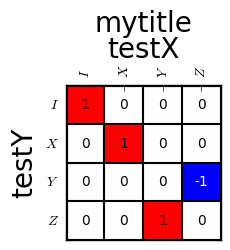

In [4]:
pplt.gate_matrix_boxplot(gs_target['Gx'], mxBasis="pp", mxBasisDims=2, xlabel="testX", ylabel="testY", title="mytitle", boxLabels=True)

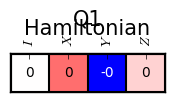

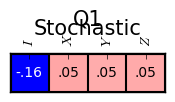

In [7]:
errgen = pygsti.tools.error_generator(gs_mc2gst['Gx'], gs_target['Gx'], "logG-logT")
hamProjs = pygsti.tools.pauliprod_errgen_projections(errgen, "hamiltonian", "gm")
stoProjs = pygsti.tools.pauliprod_errgen_projections(errgen, "stochastic", "gm")

pplt.pauliprod_projection_boxplot(hamProjs,title="Hamiltonian",boxLabels=True)
pplt.pauliprod_projection_boxplot(stoProjs,title="Stochastic",boxLabels=True)

Many of the plots in the following examples plot groups of boxes.  Each group corresponds to a particular "base" gate string that is sandwiched between sets of fiducial gate strings to create the group.  Here we create a "gate-string-dictionary" which associates a base gate string with a (x,y) coordinate pair.  Plotting functions take sets of X-coordinates (`Xs`) and Y-coordinates (`Ys`) to plot, along with a gate string dictionary (`gateStrDict`) which serves as a lookkup table for base gate strings.  

In [8]:
#Collect data we need for making plots
Xs = maxLengthList[1:]; xlbl = r"$L$ (max length)"
Ys = germList; ylbl = "Germ"
gateStrDict = { (x,y):pygsti.construction.repeat_with_max_length(y,x,False) for x in Xs for y in Ys }

#remove duplicates by replacing duplicate strings with None
runningList = []
for x in Xs:
    for y in Ys:
        if gateStrDict[(x,y)] in runningList:
            gateStrDict[(x,y)] = None
        else: runningList.append( gateStrDict[(x,y)] )

## $\chi^2$ Plots

One of the most straightforward ways to evaluate GST estimates is to ask whether the estimates correctly reproduce the observed frequencies of the counts (or "clicks") for the experiments. The answer to this question is to compute the $\chi^{2}$ function for the gateset.

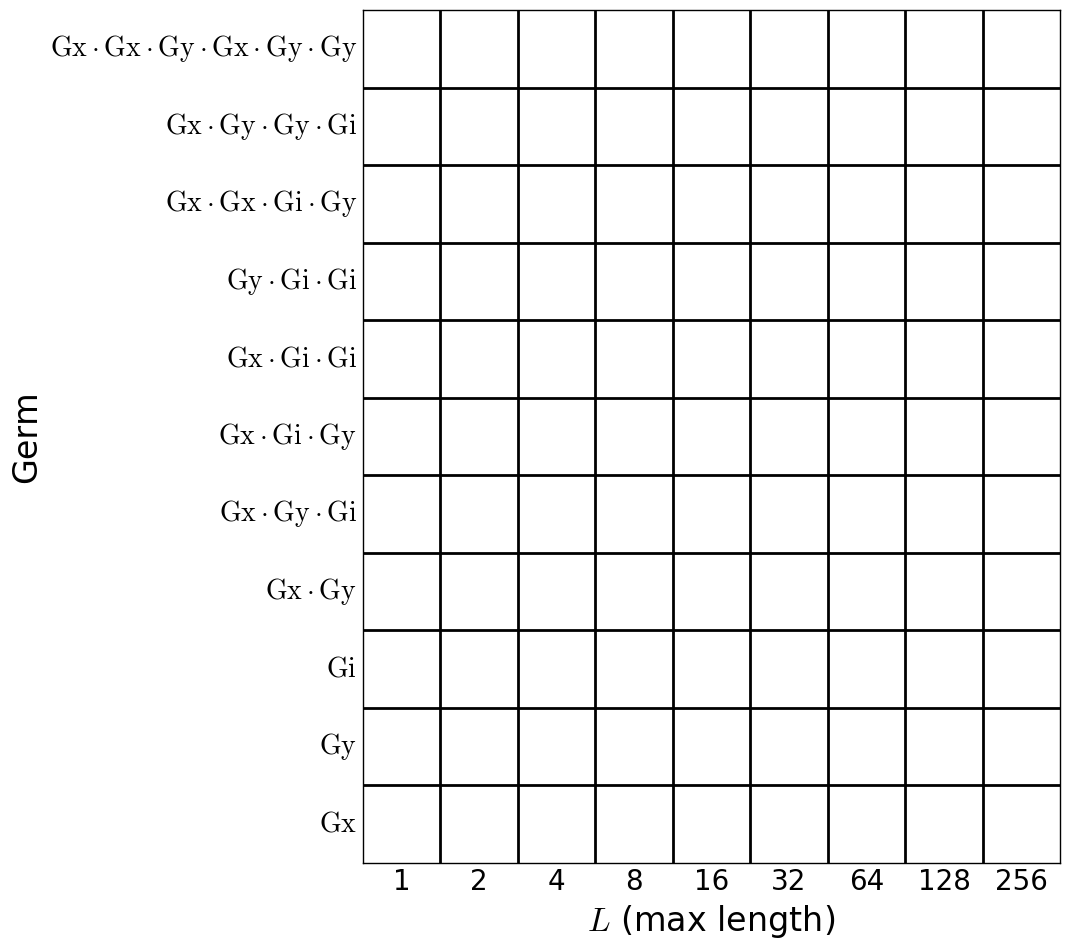

In [9]:
#Demonstrates a blank chi2 boxplot
pplt.blank_boxplot( Xs, Ys, gateStrDict, strs, xlbl, ylbl, sumUp=True, ticSize=20)

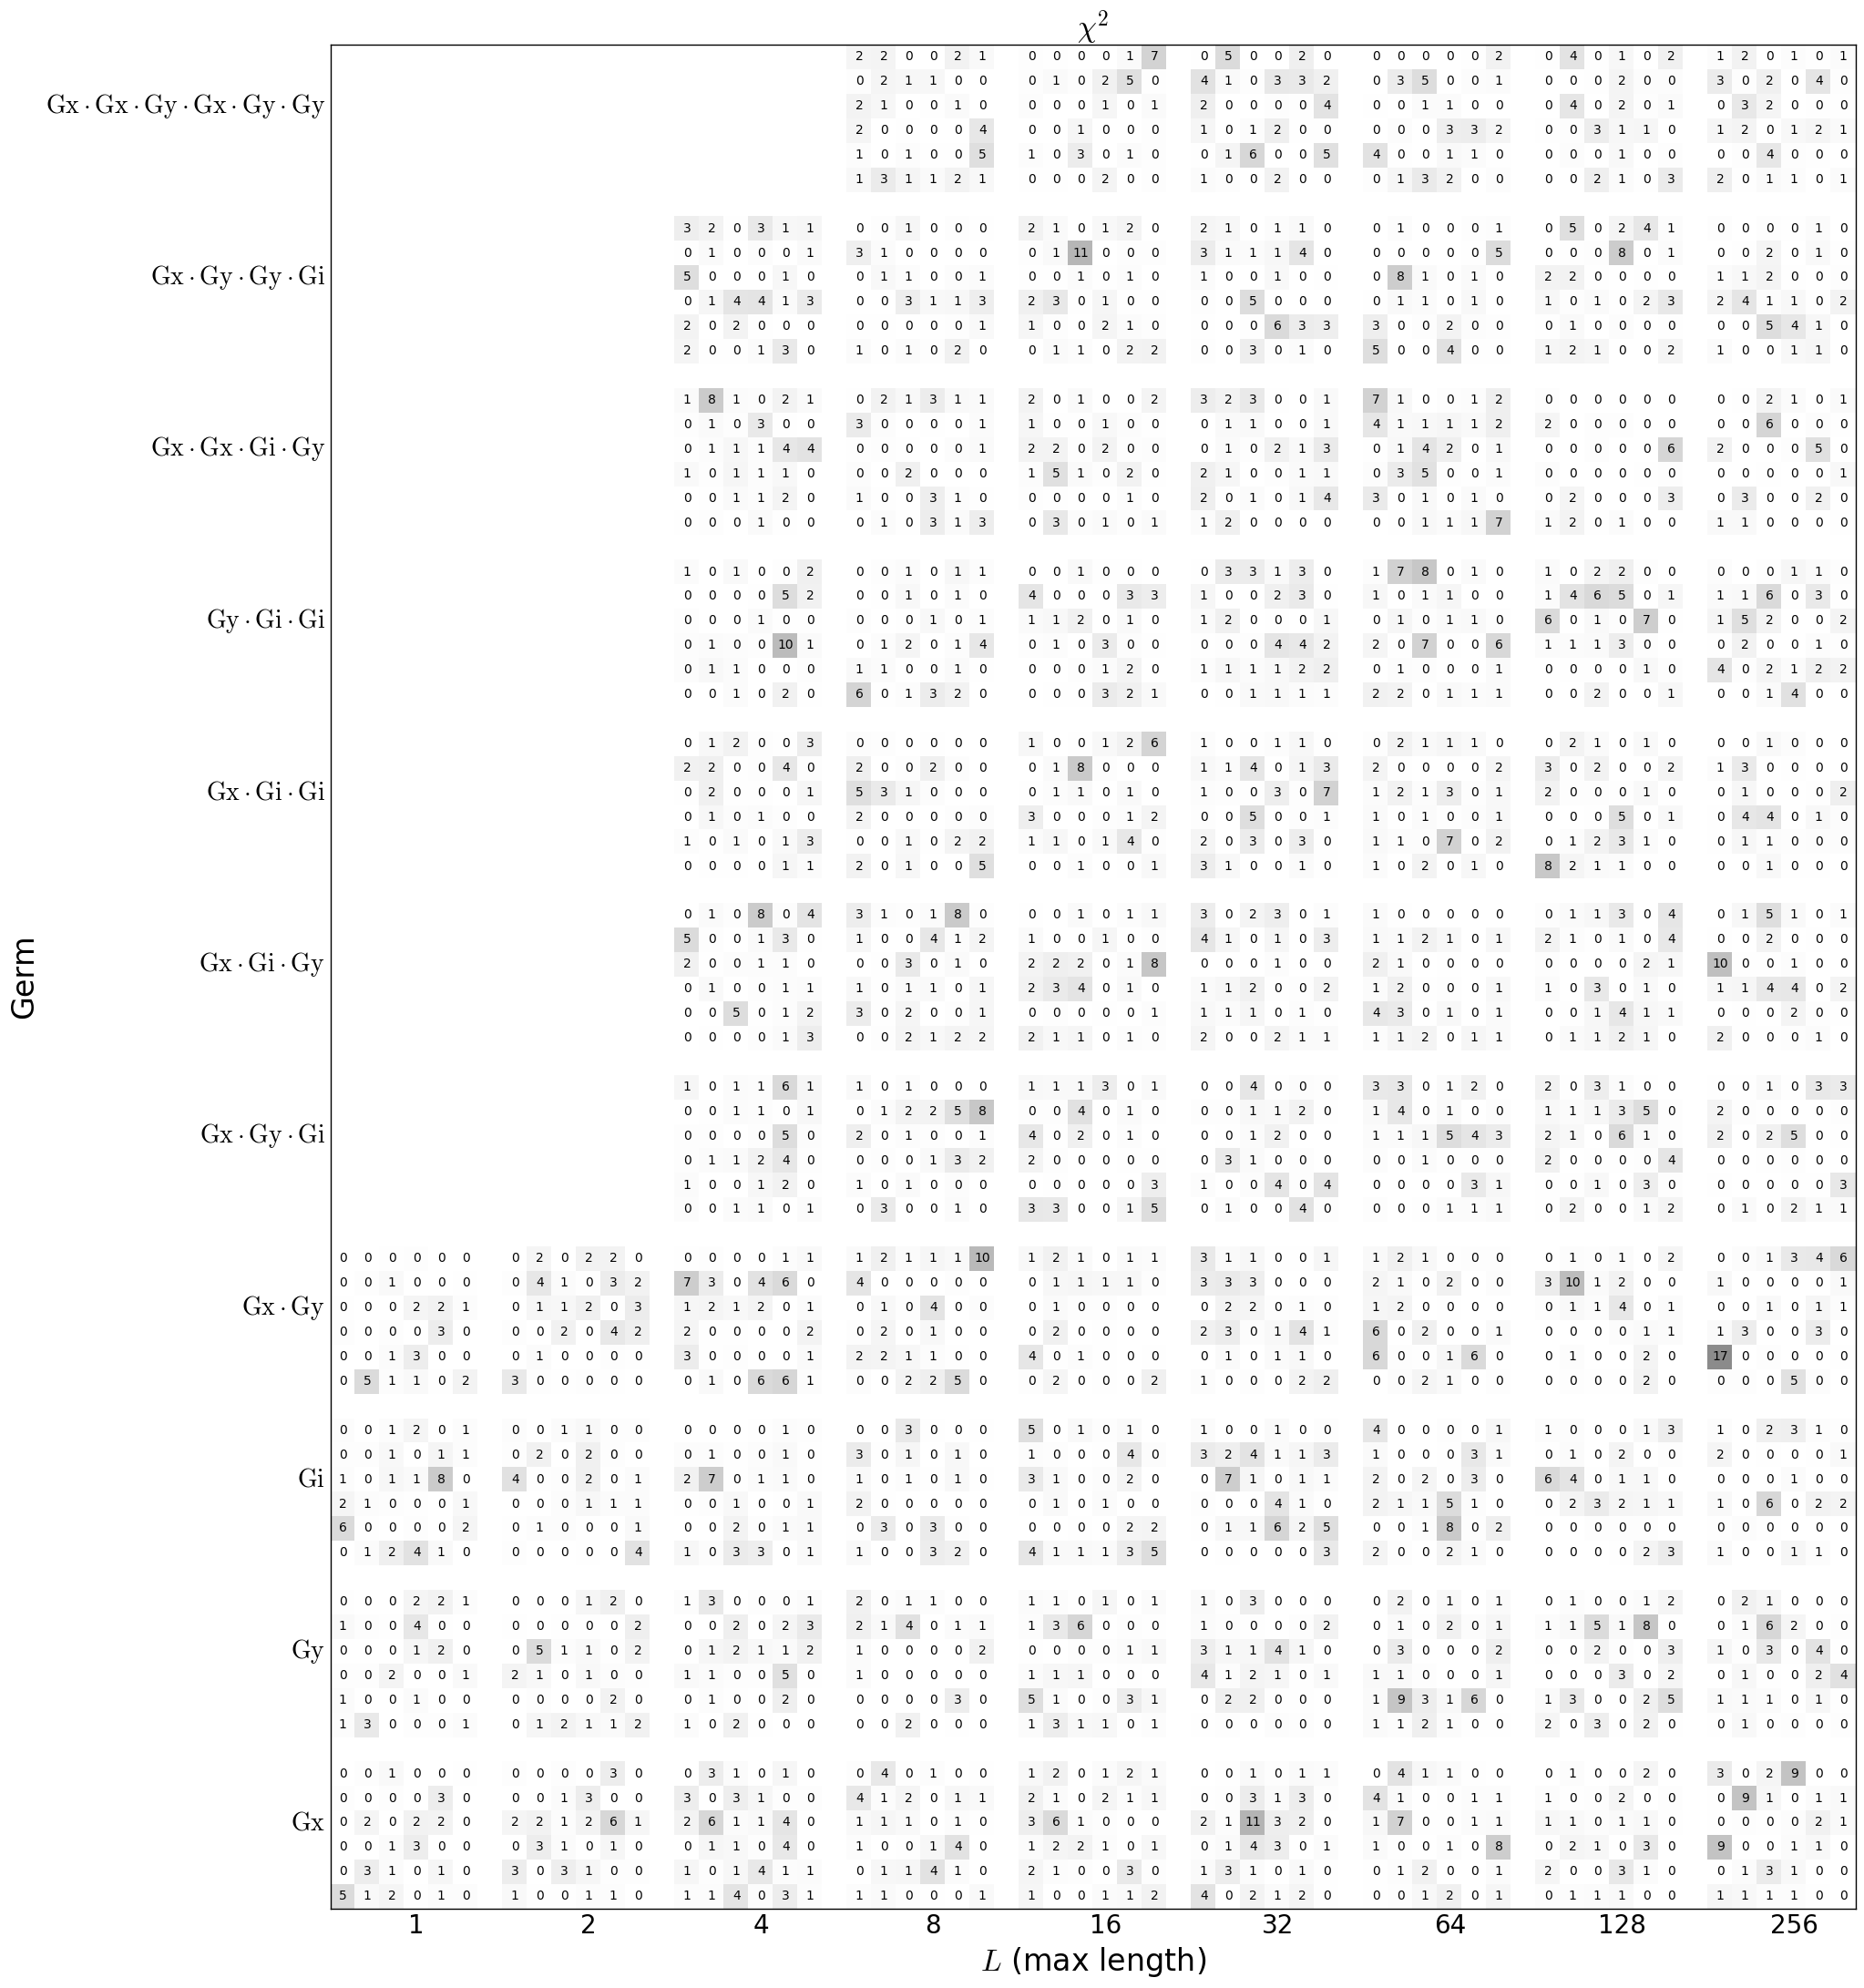

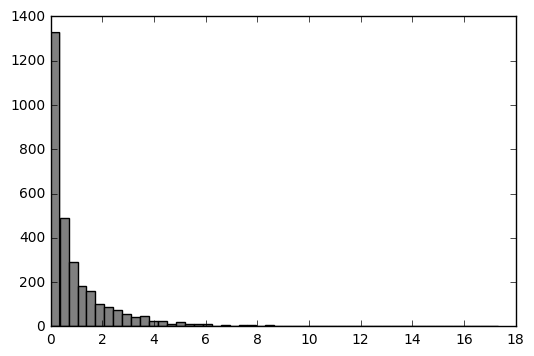

In [10]:
#Compute the chi2 scores for the estimated gateset using the MC2GST algorithm
pplt.chi2_boxplot( Xs, Ys, gateStrDict, ds, gs_mc2gst, strs, xlbl, ylbl,
                   scale=1.0, sumUp=False, histogram=True)

Because most of the $\chi^{2}$ values are close to 0, we conclude this estimated gateset does a good job of reproducing the observed frequencies. Which it should, since the figure of merit we were using in our estimation was the $\chi^{2}$ function!

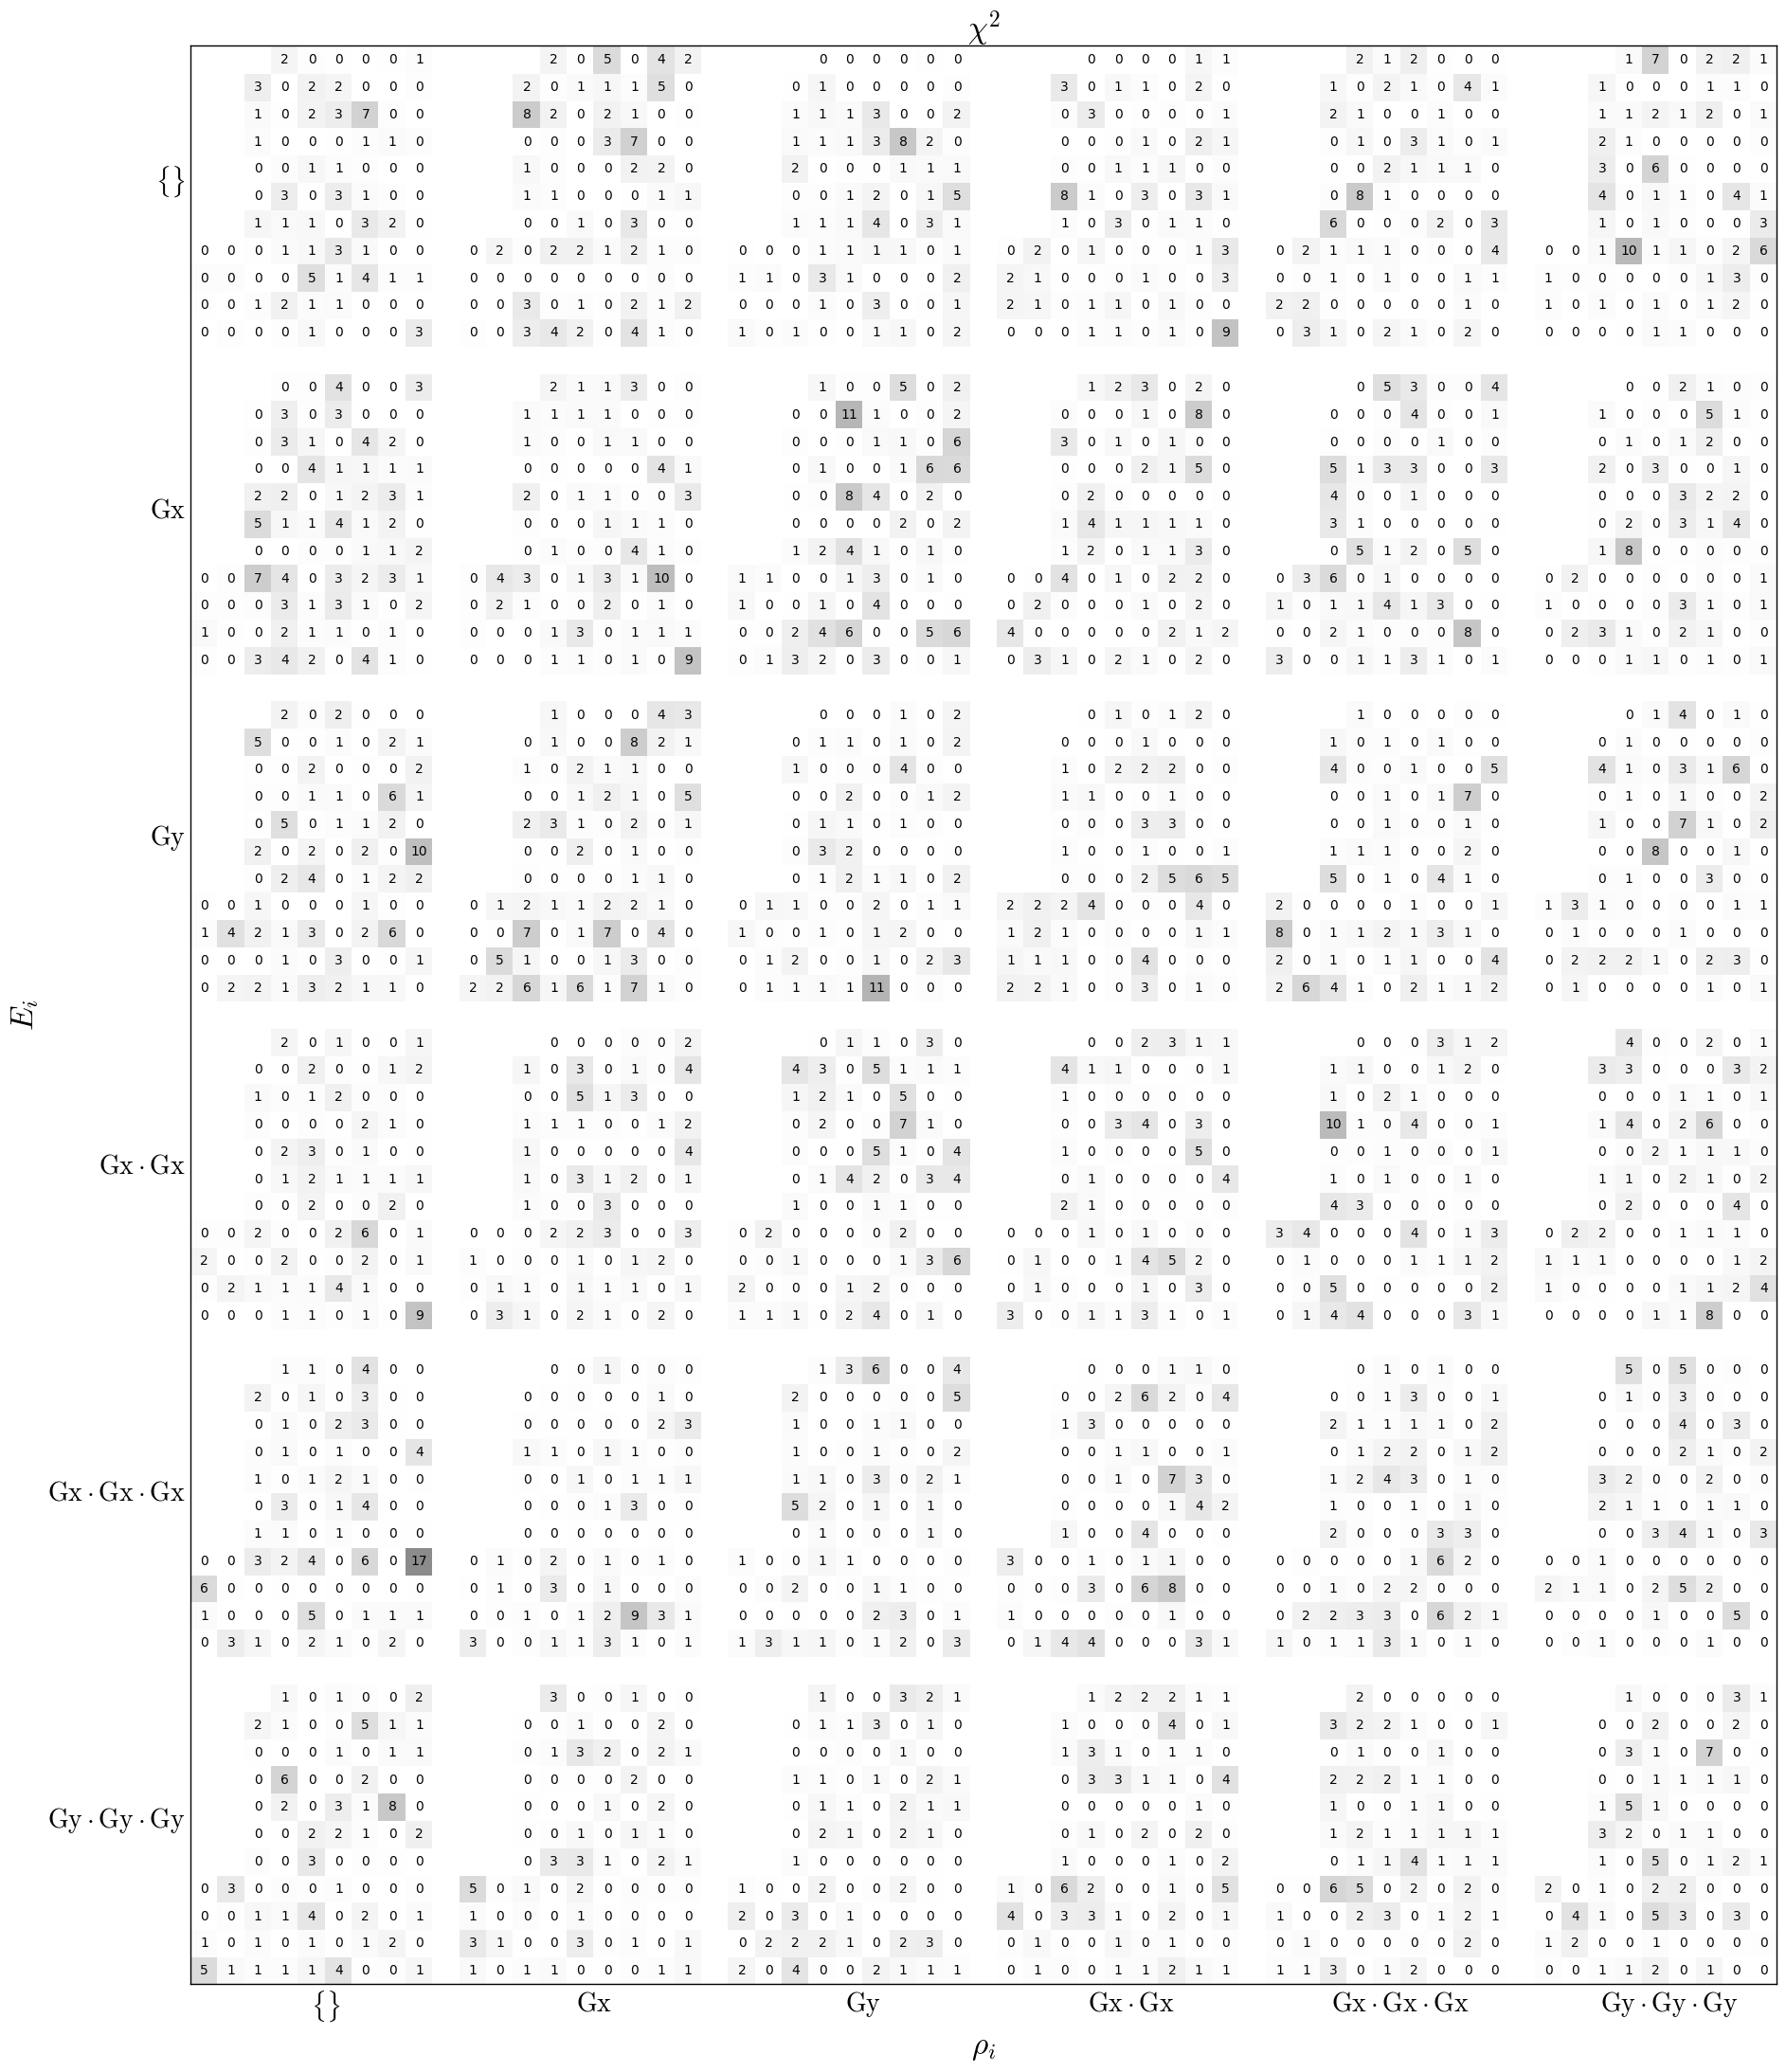

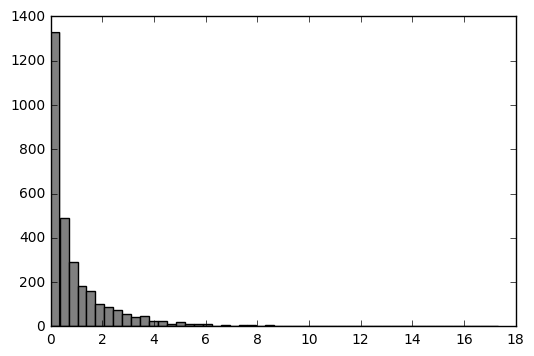

In [11]:
#Make another chi2 plot, with different x and y labels
pplt.chi2_boxplot( Xs, Ys, gateStrDict, ds, gs_mc2gst, strs, xlbl, ylbl,
               scale=1.0, sumUp=False, histogram=True, invert=True)

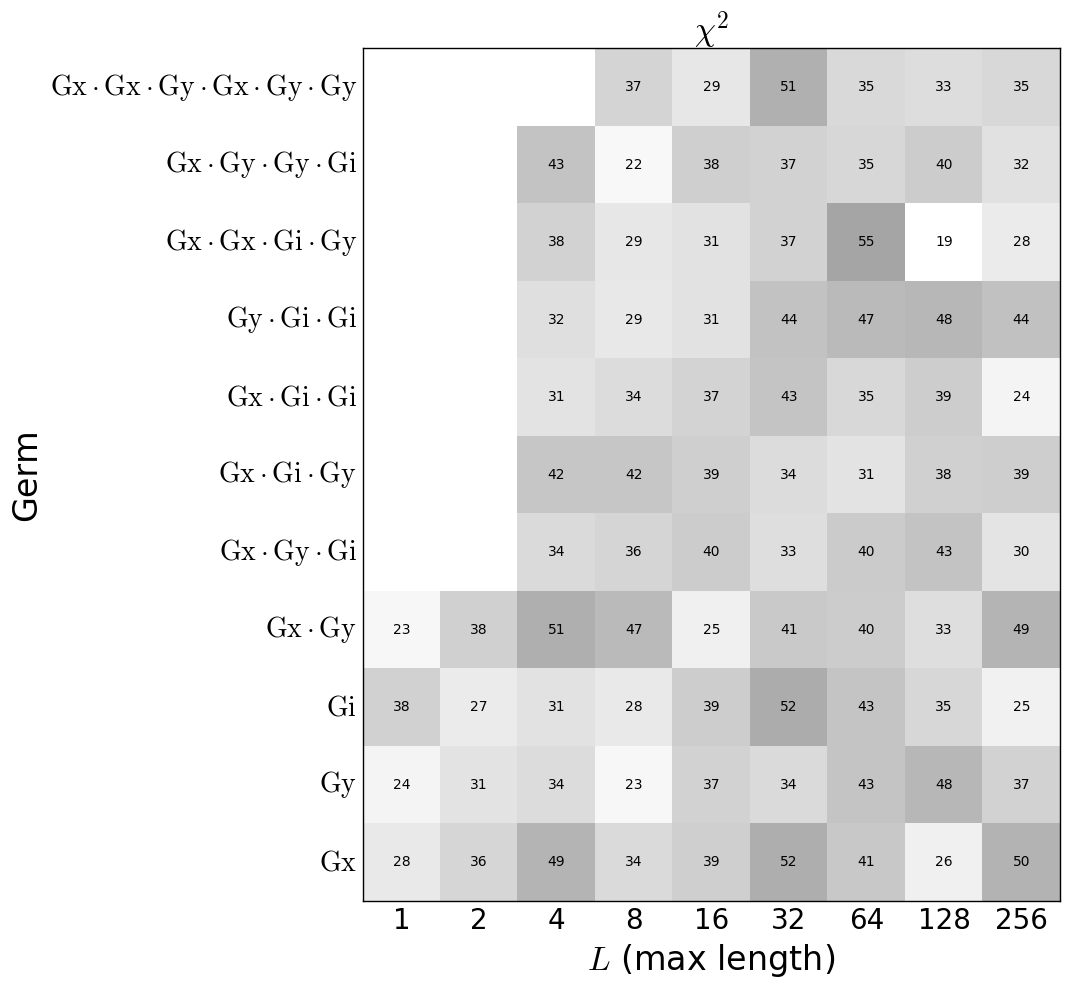

In [12]:
#Sum up the chi2 boxes for each (Germ, L) pair
pplt.chi2_boxplot( Xs, Ys, gateStrDict, ds, gs_mc2gst, strs, xlbl, ylbl,
                scale=1.0, sumUp=True)

## Direct $\chi^2$ Plots

In [13]:
directLGST = pplt.direct_lgst_gatesets( [gs for gs in gateStrDict.values() if gs is not None],
                                ds, specs, gs_target, svdTruncateTo=4, verbosity=2)
directLSGST = pplt.direct_mc2gst_gatesets( [gs for gs in gateStrDict.values() if gs is not None],
                                ds, specs, gs_target, svdTruncateTo=4, minProbClipForWeighting=1e-2, 
                                probClipInterval=(-1e6,1e6), verbosity=2)

#focusedGS = AT.focused_mc2gst_gatesets( [gs for gs in gateStrDict.values() if gs is not None],
#                                ds, specs, gs_mc2gst, minProbClipForWeighting=1e-2, 
#                                probClipInterval=(-1e6,1e6), verbosity=2)

--- Direct LGST precomputation ---
--- Computing gateset for string - Iter 01 of 84 ---: 
--- LGST ---
  Singular values of I_tilde (truncating to first 4 of 6) = 
  2.99042918449
  0.834913690109
  0.671124159739
  0.664754312975
  0.0224691987452
  0.0112970484379
  
  Singular values of target I_tilde (truncating to first 4 of 6) = 
  3.0
  1.0
  1.0
  1.0
  2.46365884775e-16
  9.80956846773e-17
  
--- Computing gateset for string - Iter 02 of 84 ---: 
--- LGST ---
  Singular values of I_tilde (truncating to first 4 of 6) = 
  2.99042918449
  0.834913690109
  0.671124159739
  0.664754312975
  0.0224691987452
  0.0112970484379
  
  Singular values of target I_tilde (truncating to first 4 of 6) = 
  3.0
  1.0
  1.0
  1.0
  2.46365884775e-16
  9.80956846773e-17
  
--- Computing gateset for string - Iter 03 of 84 ---: 
--- LGST ---
  Singular values of I_tilde (truncating to first 4 of 6) = 
  2.99042918449
  0.834913690109
  0.671124159739
  0.664754312975
  0.0224691987452
  0.0112970

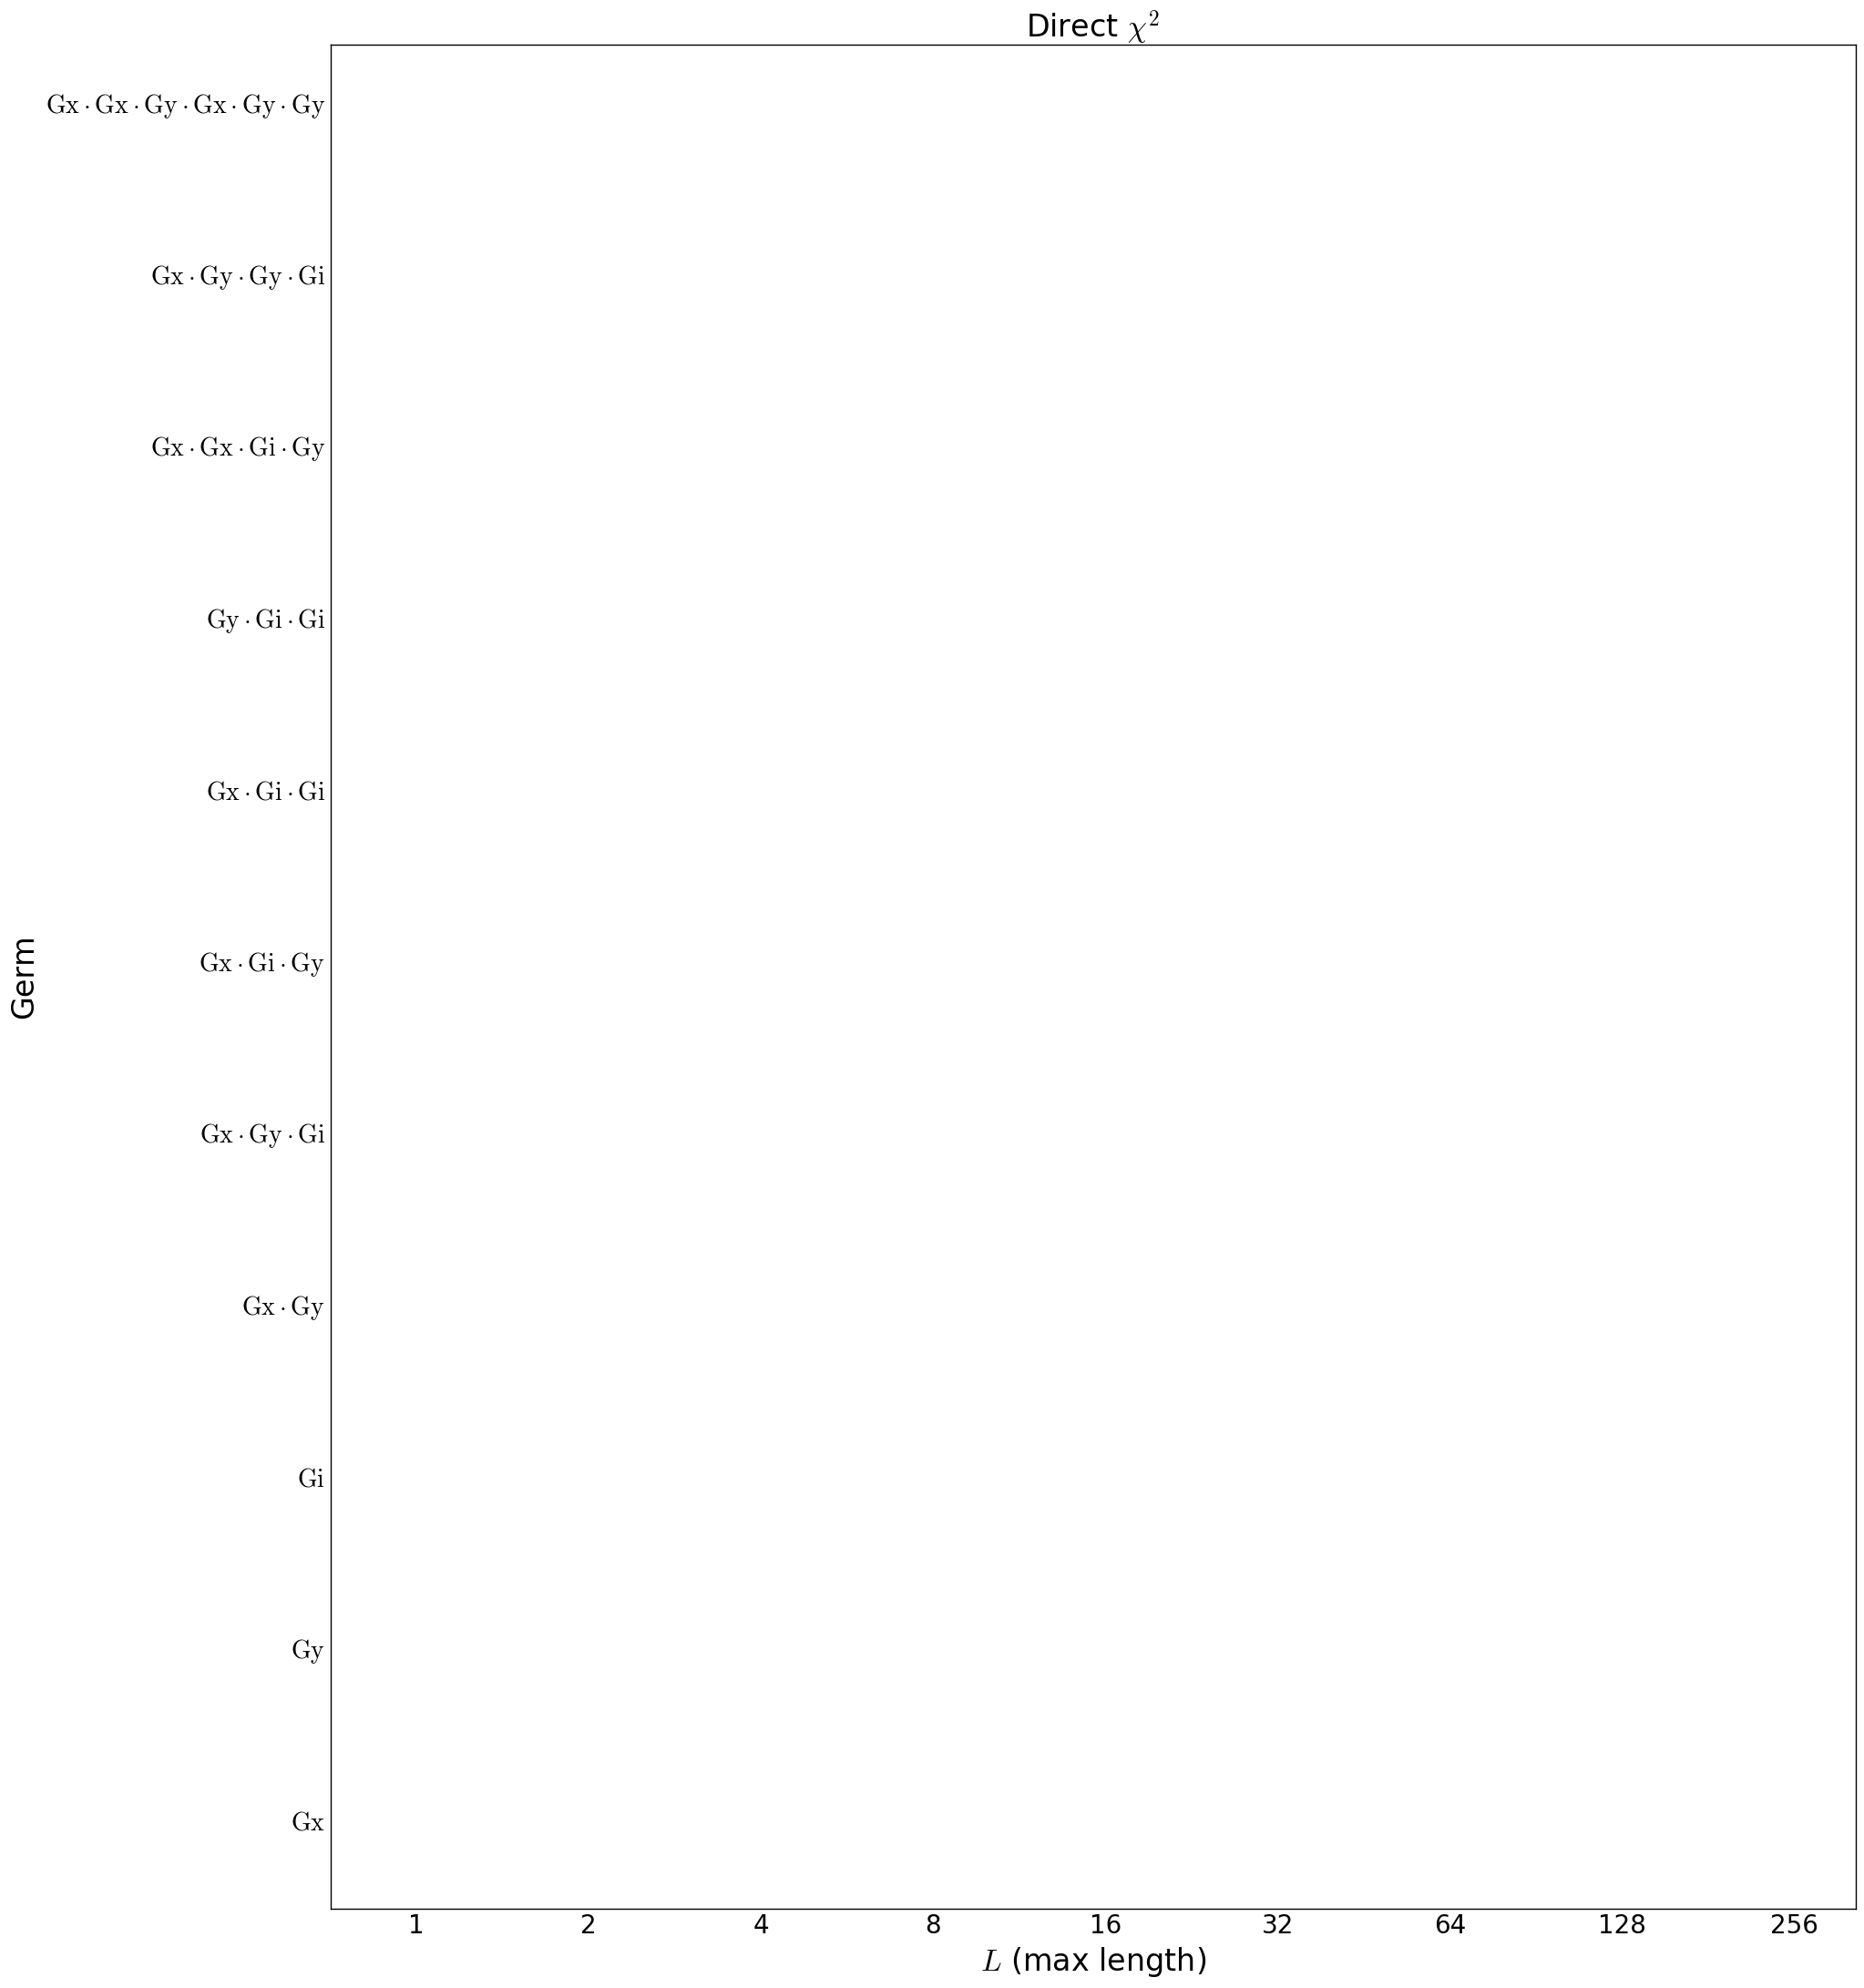

In [14]:
pplt.direct_chi2_boxplot( Xs, Ys, gateStrDict, ds, directLSGST, strs, xlbl, ylbl,
                          scale=1.0, boxLabels=True )

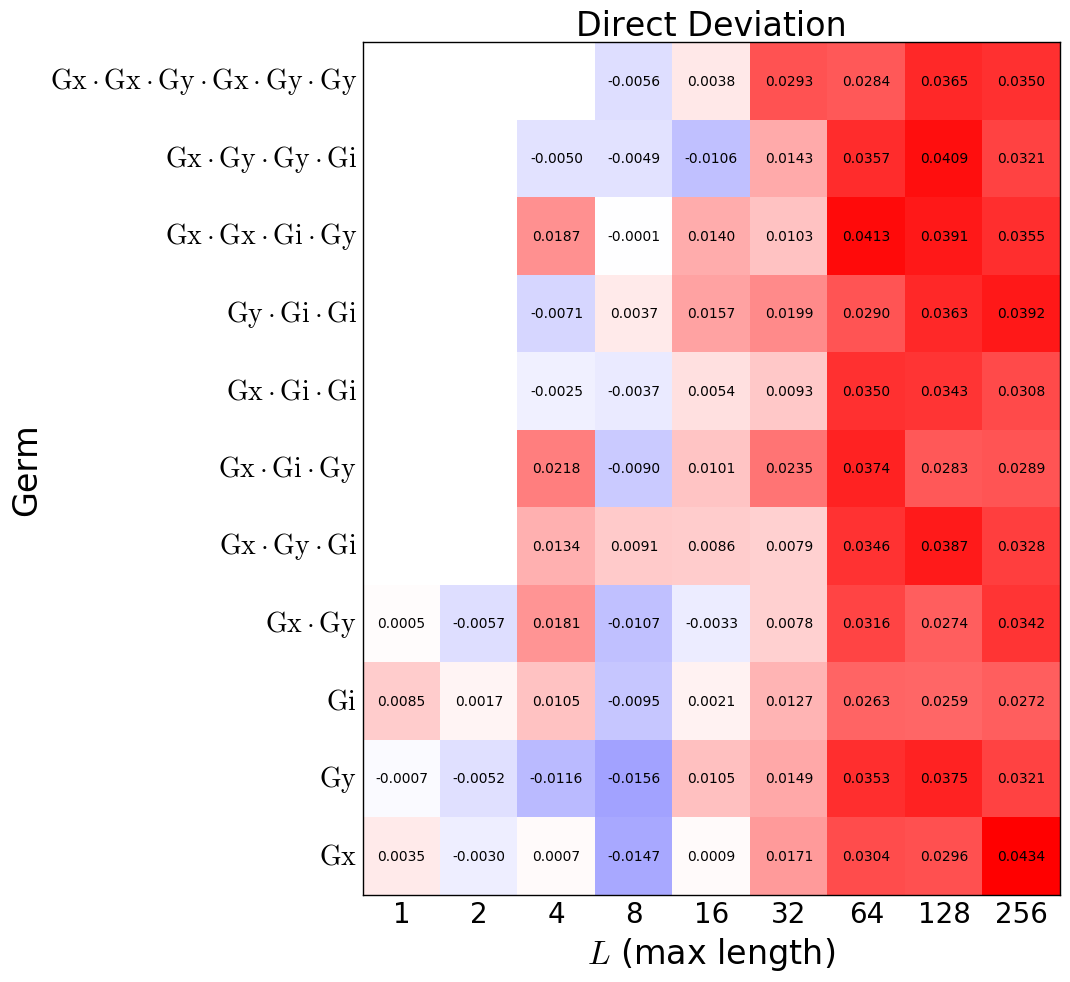

In [15]:
pplt.direct_deviation_boxplot(Xs, Ys, gateStrDict, ds, gs_mc2gst, directLSGST, xlbl, ylbl, prec=4,
                        scale=1.0, boxLabels=True)

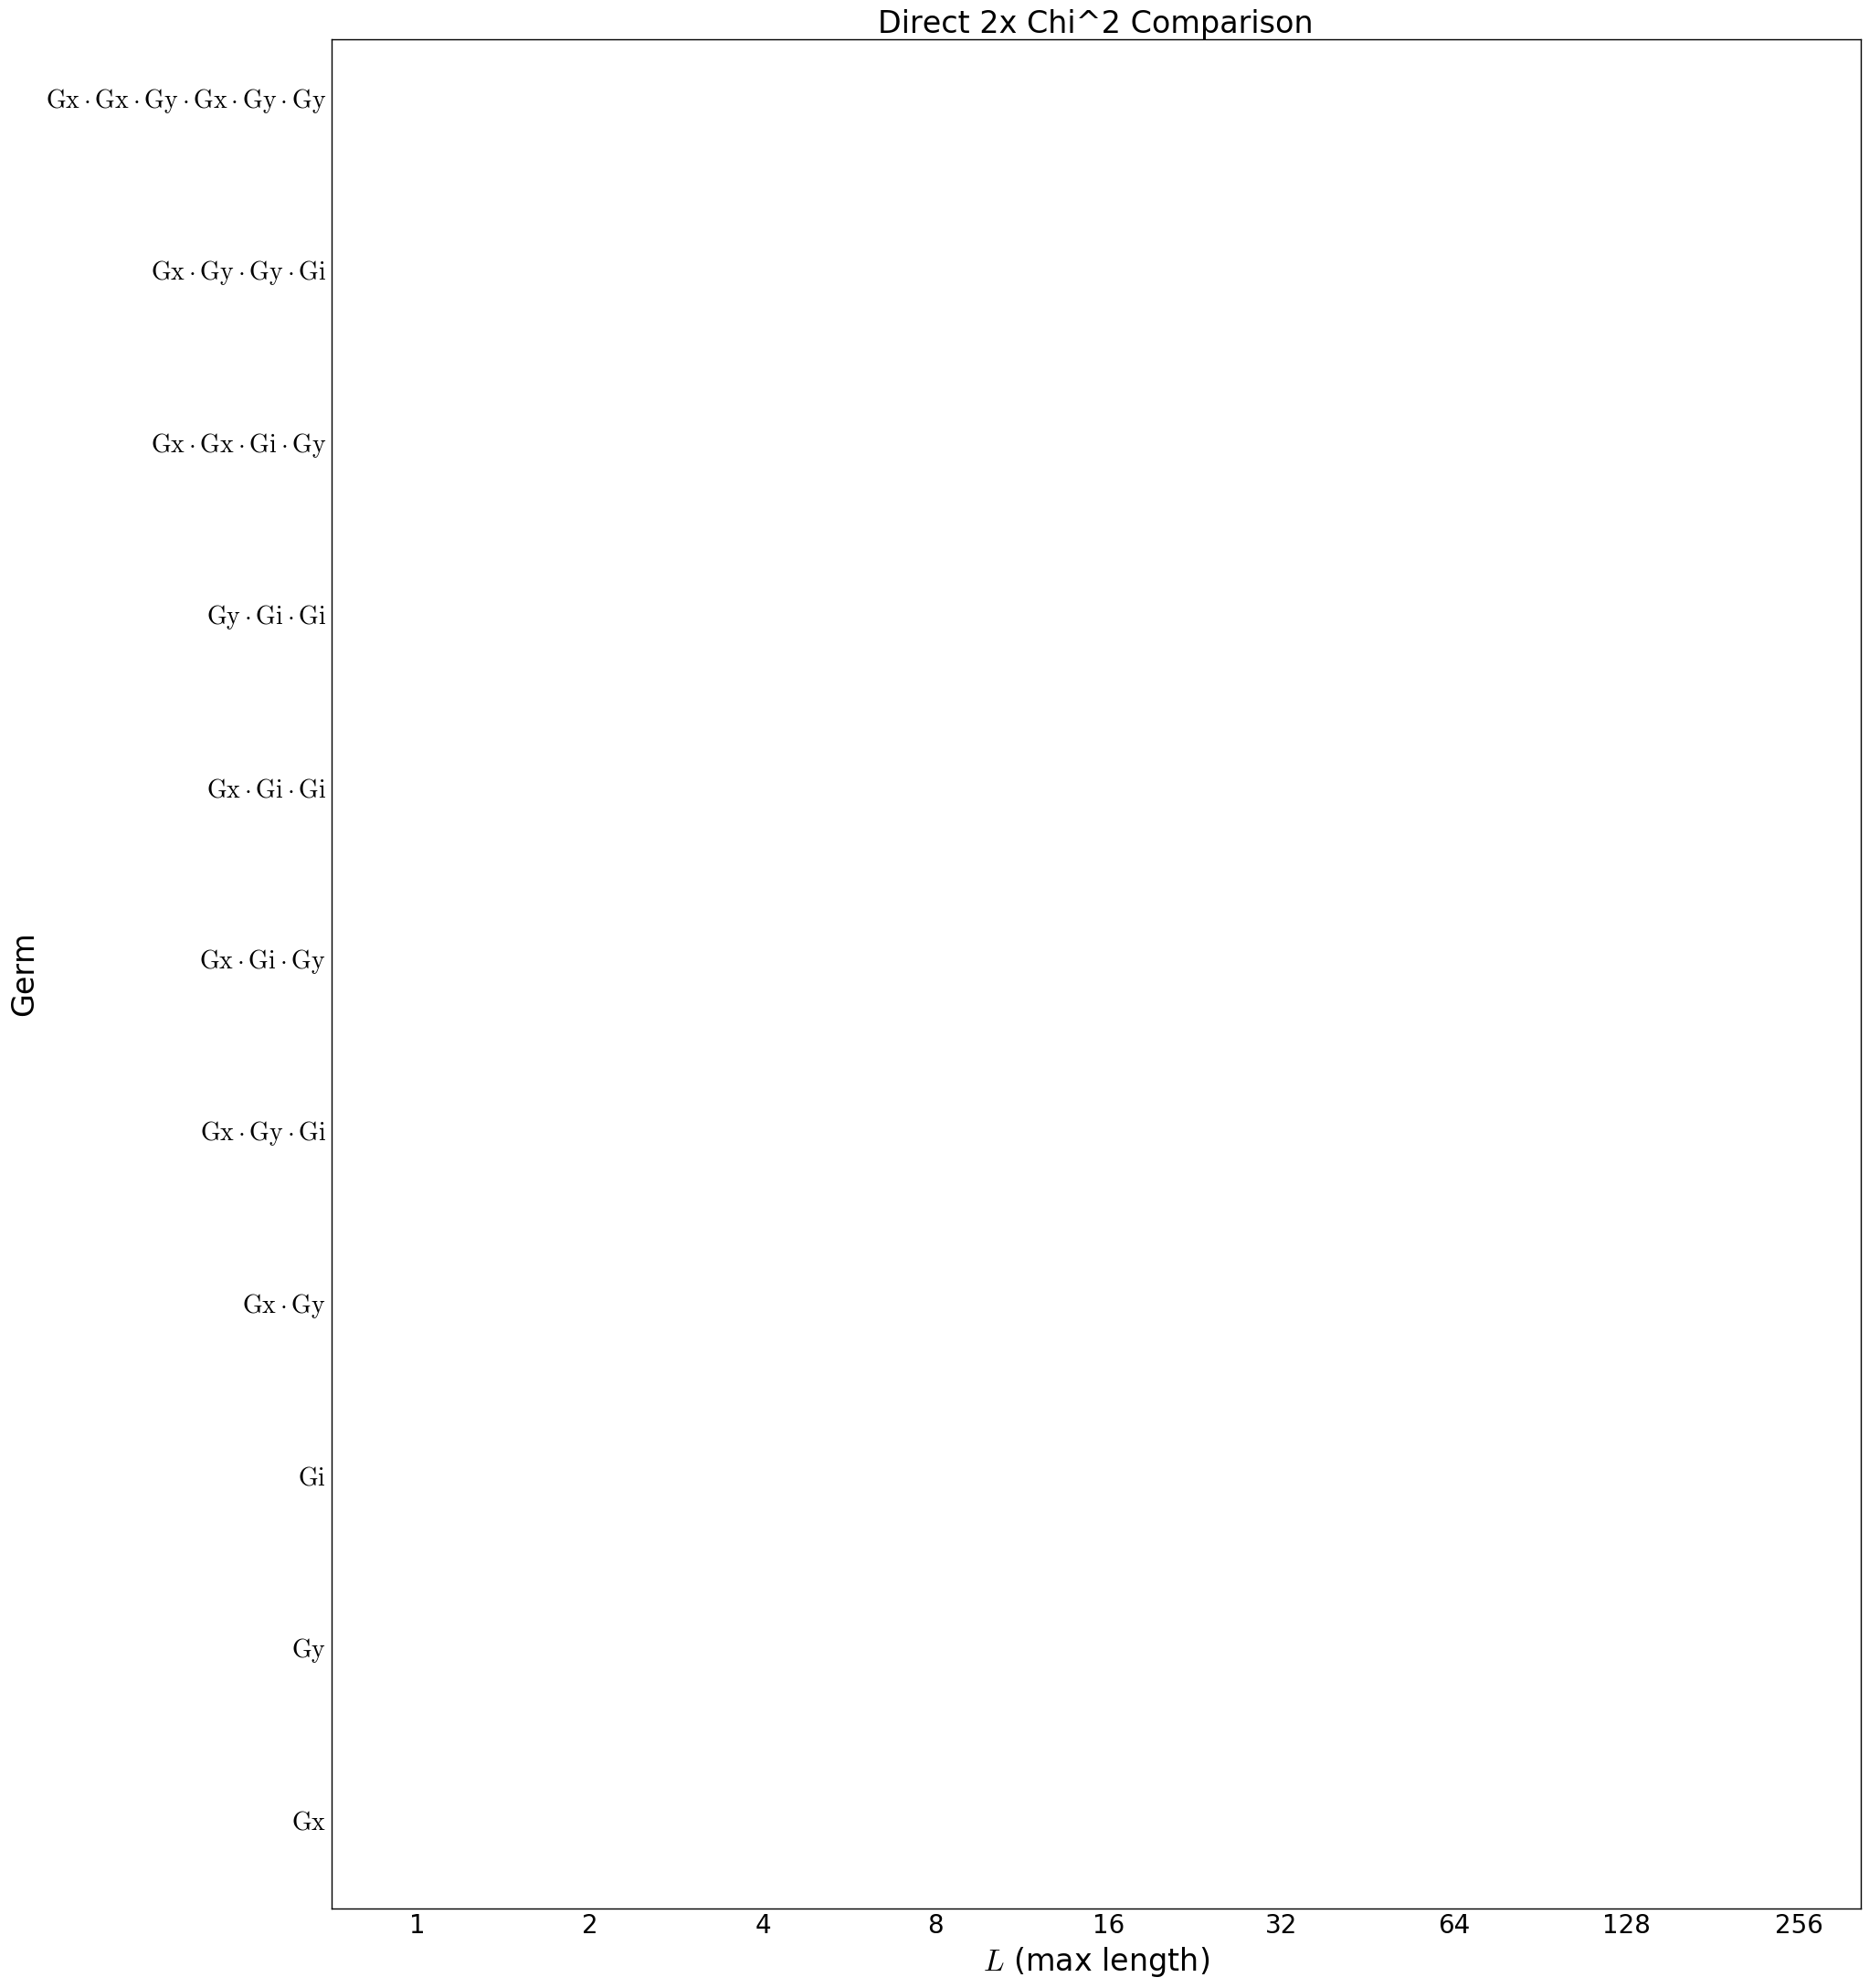

In [16]:
pplt.direct2x_comp_boxplot( Xs, Ys, gateStrDict, ds, directLSGST, strs, xlbl, ylbl,
                        scale=1.0, boxLabels=True )

## Error Rate Plots (uses Direct-X results)

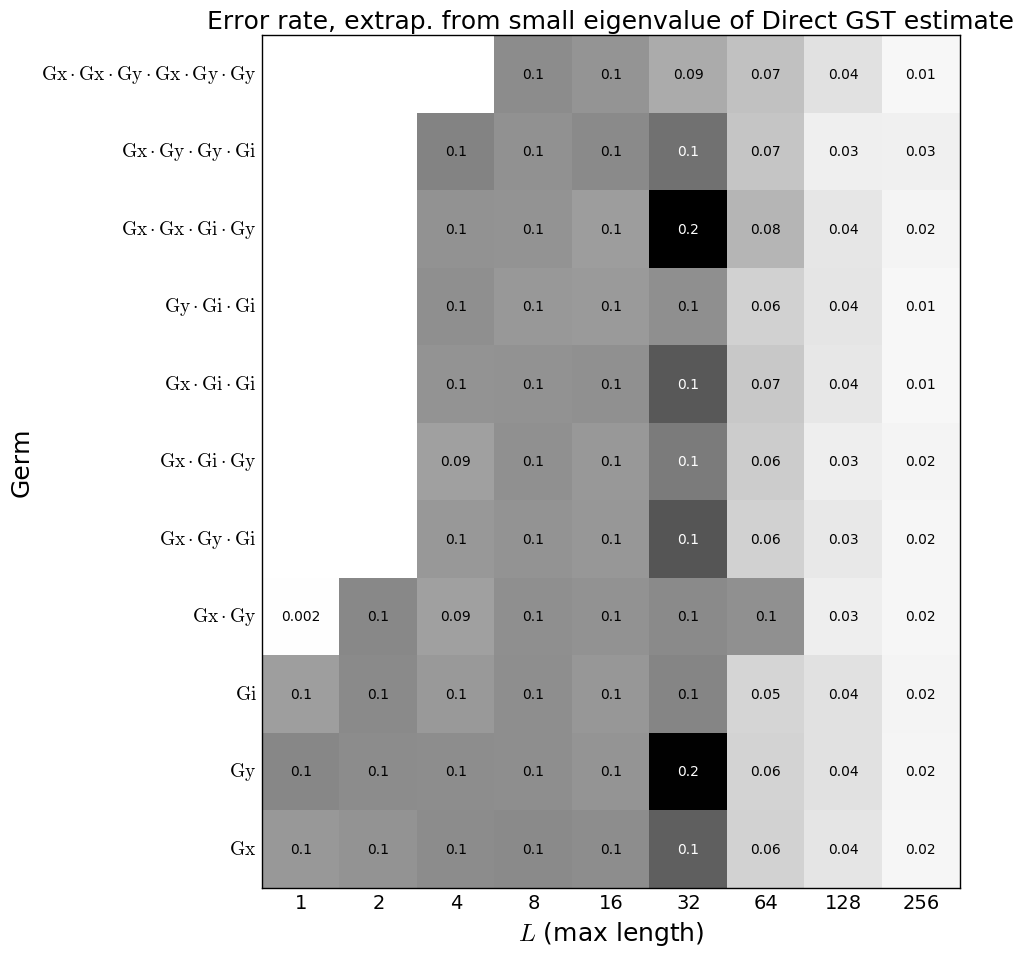

In [17]:
pplt.small_eigval_err_rate_boxplot(Xs, Ys, gateStrDict, ds, directLSGST, xlbl, ylbl,
                             scale=1.0, boxLabels=True)

## Whack-a-$\chi^2$-mole Plots

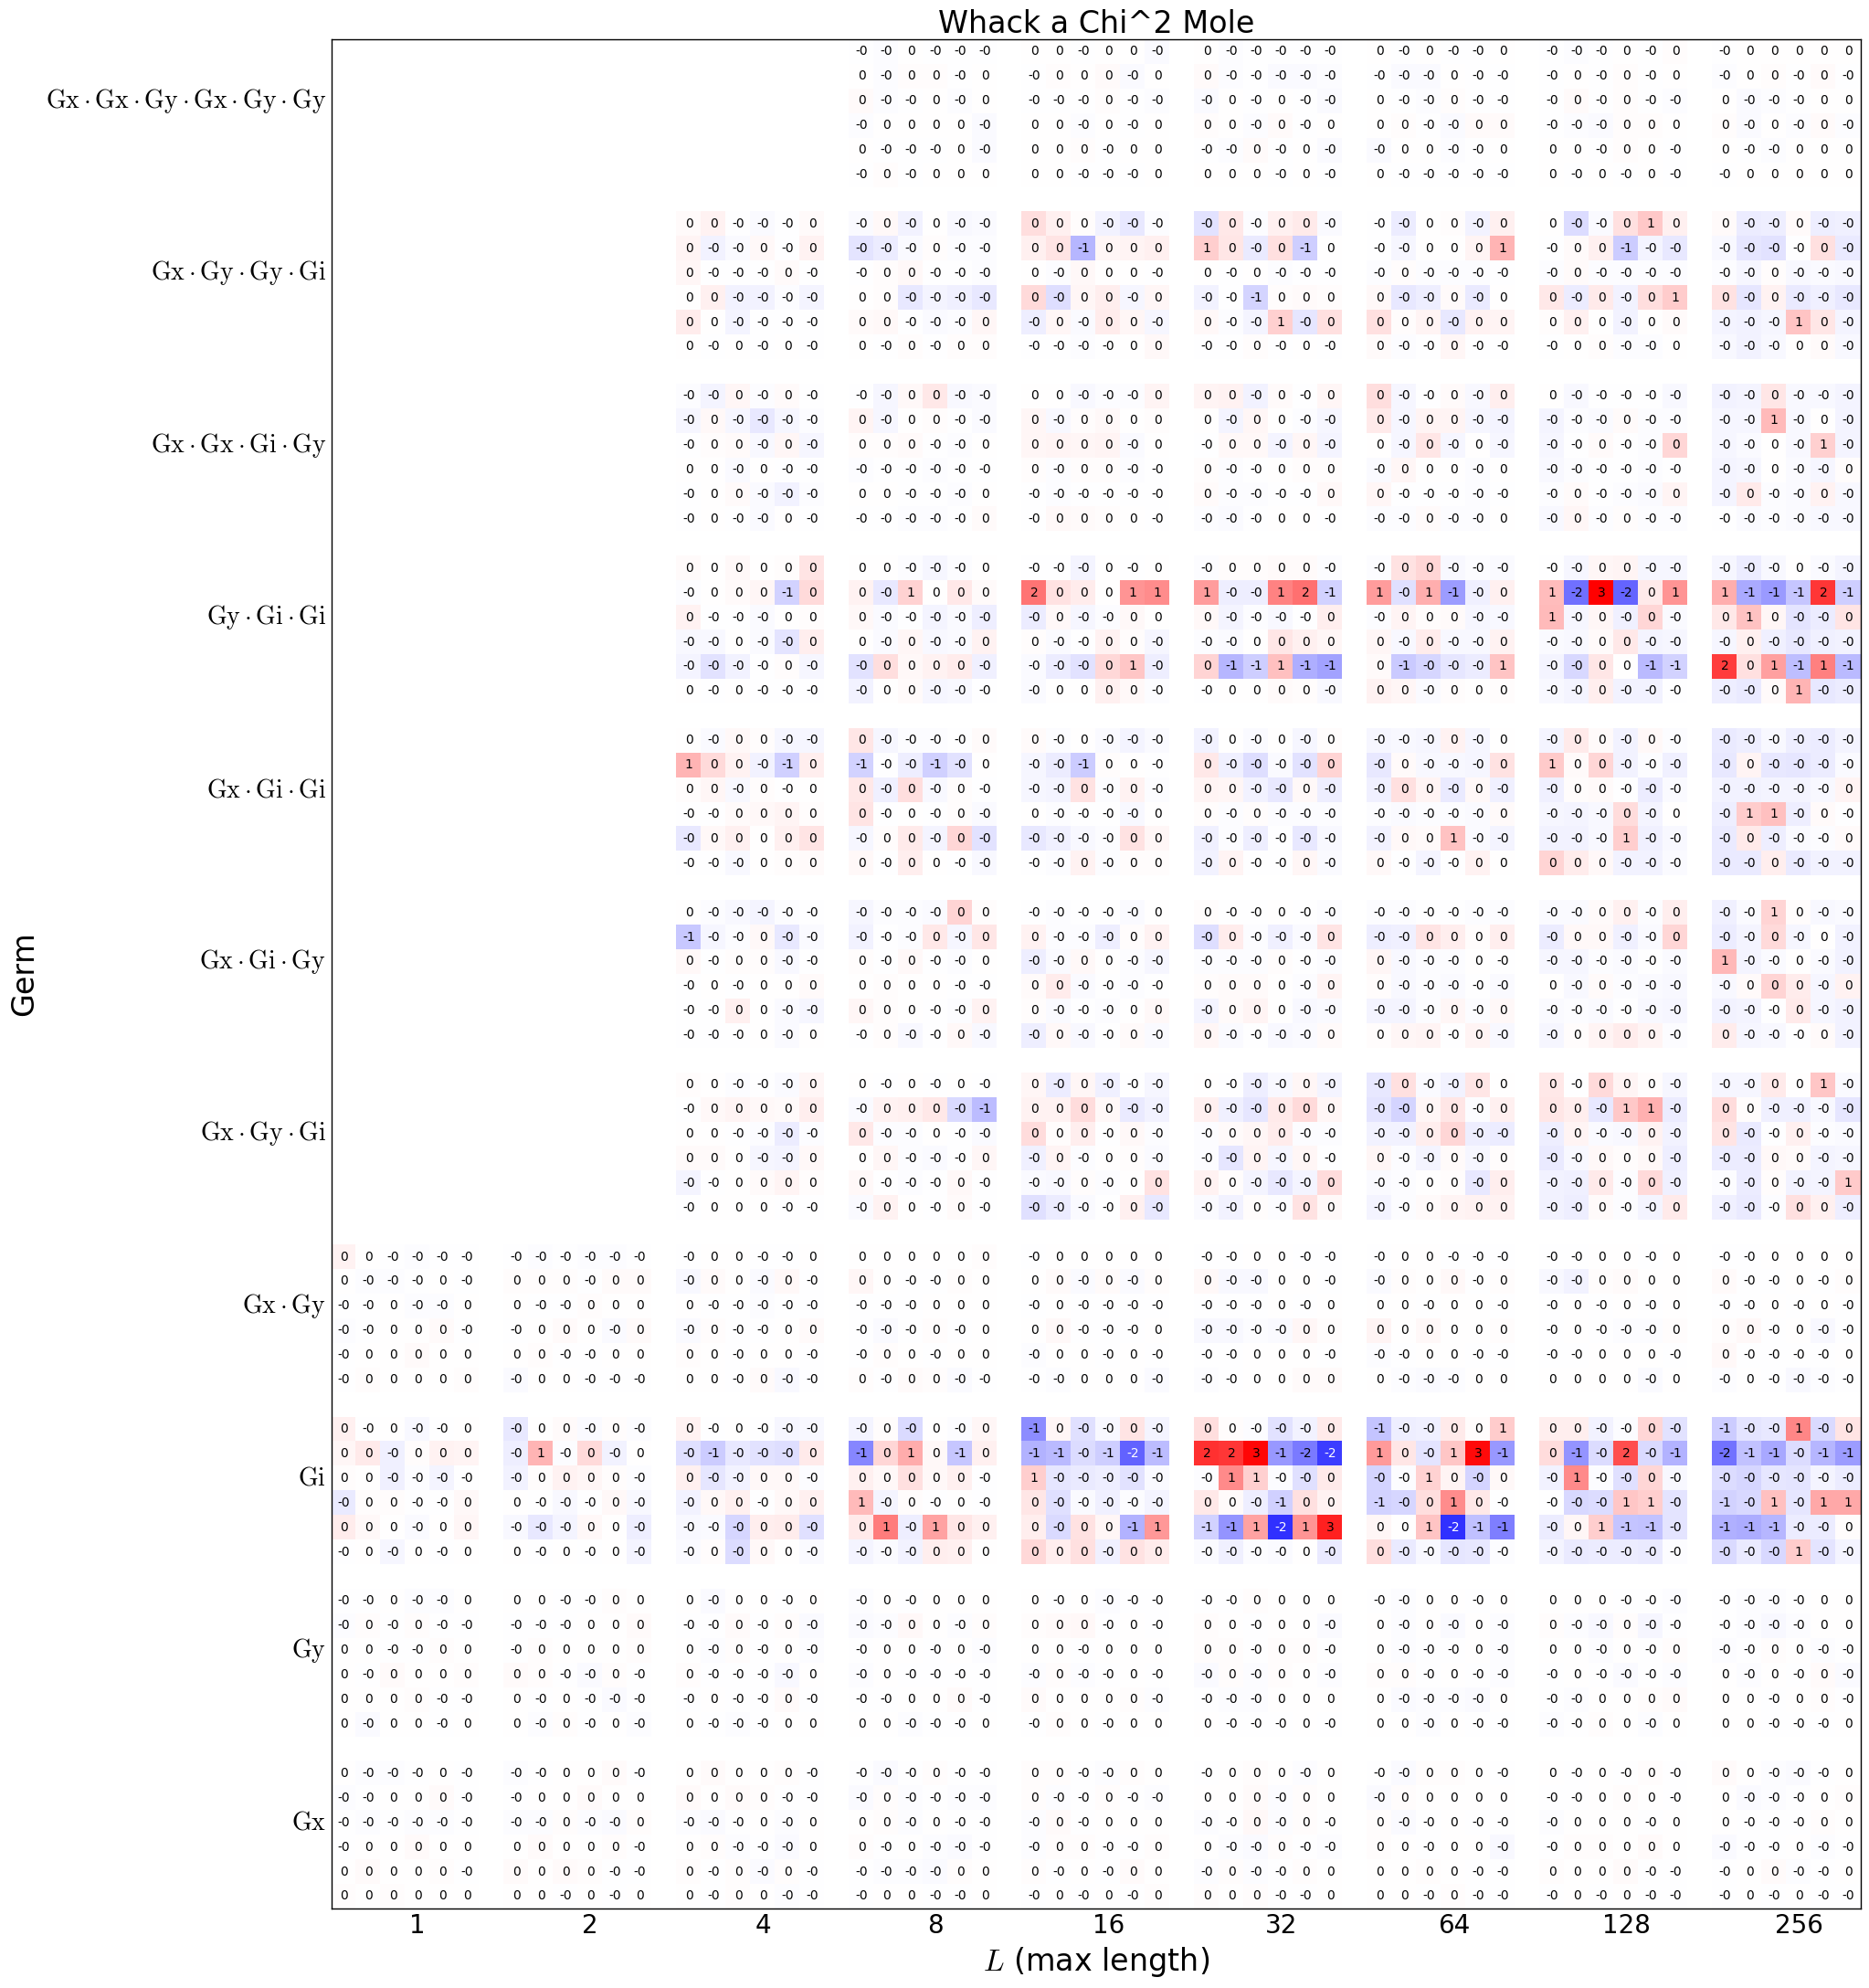

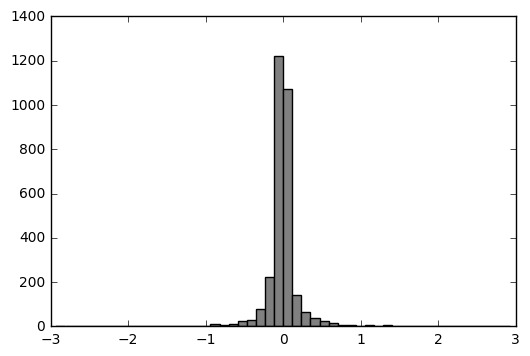

In [18]:
whack = pygsti.objects.GateString( ('Gi',)*256 )
fullGatestringList = pygsti.io.load_gatestring_list("tutorial_files/Example_LSGSTlist256.txt")
pplt.whack_a_chi2_mole_boxplot( whack, fullGatestringList, Xs, Ys, gateStrDict, ds, gs_mc2gst, strs, xlbl, ylbl,
               scale=1.0, sumUp=False, histogram=True )

## Other plots

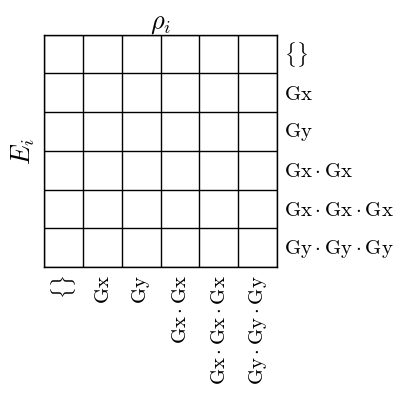

In [19]:
pplt.gof_boxplot_keyplot(strs)

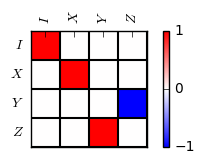

In [20]:
pplt.gate_matrix_boxplot(gs_target['Gx'], mxBasis="gm", mxBasisDims=2)

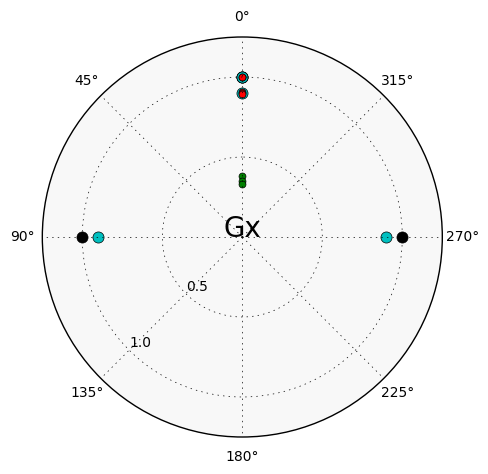

In [21]:
pplt.polar_eigenval_plot(gs_mc2gst['Gx'], gs_target['Gx'], size=(4,4), title="Gx")

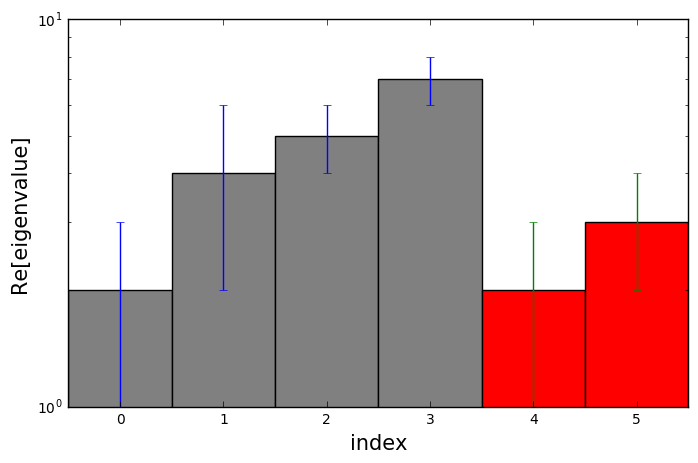

In [22]:
pplt.choi_eigenvalue_barplot([2,4,5,7,-2,-3],[1,2,1,1,1,1])